Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [8]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [174]:
df.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

#Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df['Date'].tail()

418   2019-08-27
419   2019-08-27
420   2019-08-27
421   2019-08-27
422   2019-08-27
Name: Date, dtype: datetime64[ns]

In [12]:
df['Date'].dt.year

0      2016
1      2016
2      2016
3      2016
4      2016
       ... 
418    2019
419    2019
420    2019
421    2019
422    2019
Name: Date, Length: 421, dtype: int64

In [13]:
#create test DataFrame
condition_test = df['Date'].dt.year >= 2018
df_test = df[condition_test]
df_test.head(5)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [14]:
#replace False with 0 and True with 1
df_test['Great'] = df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_test.shape

(38, 59)

In [16]:
#create train 
condition_train = df['Date'].dt.year <= 2016
df_train = df[condition_train]
df_train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [17]:
df_train.shape

(298, 59)

In [18]:
#validate DataFrame
condition_val = df['Date'].dt.year == 2017
df_val = df[condition_val]
df_val.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
303,Other,2017-01-07,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
304,Other,2017-01-07,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
305,Other,2017-01-10,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [19]:
df_val.shape

(85, 59)

#Begin with baselines for classification.

In [49]:
#determine the majority class
target = "Great"
y_train = df_train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [55]:
#What if we guessed the majority class for every prediction?
majority_class = y_train.mode()[0] #mode() gets the most frequent on in the array
y_train.mode()[0]

False

In [22]:
y_train.head()

0    False
1    False
2    False
3    False
4     True
Name: Great, dtype: bool

In [0]:
y_pred_train = [majority_class]*len(y_train)

In [25]:
y_pred_train[:5]

[False, False, False, False, False]

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [27]:
#validation
y_val = df_val[target]
y_pred = [majority_class]*len(y_val)

accuracy_score(y_val, y_pred)

0.5529411764705883

#Use scikit-learn for linear regression.

In [28]:
df_train.describe(include='all')

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,71.000000,71.000000,22,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,0.0,4,3,3,2,13,2,1,298
unique,5,110,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,NaN,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,NaN,x,x,x,x,x,X,x,False
freq,118,29,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,NaN,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.897183,4.142254,NaN,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.478680,0.371738,NaN,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.500000,2.900000,NaN,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.500000,4.000000,NaN,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

In [30]:
#1. import estimator class
from sklearn.linear_model import LinearRegression

#2. instantiate the class
linear_reg = LinearRegression()

#3. Arrange X feature matrices
features = ['Yelp', 'Google', 'Cost']
X_train = df_train[features]
X_val = df_val[features]

#impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.fit_transform(X_val)

#4 fit the model
linear_reg.fit(X_train_imputed, y_train)

#5. apply mmodel to new data
linear_reg.predict(X_val_imputed)

array([0.40063976, 0.40063976, 0.51000577, 0.47546913, 0.30796647,
       0.3965123 , 0.47489352, 0.4518691 , 0.4518691 , 0.47546913,
       0.47546913, 0.36552752, 0.42308857, 0.41503003, 0.41503003,
       0.45716609, 0.43160468, 0.47546913, 0.47546913, 0.47546913,
       0.47546913, 0.4952915 , 0.3862495 , 0.45244471, 0.39488366,
       0.39488366, 0.29415181, 0.40927392, 0.39488366, 0.40927392,
       0.43420662, 0.4956155 , 0.36552752, 0.36552752, 0.59634735,
       0.59634735, 0.20241108, 0.38049339, 0.50275105, 0.46683498,
       0.65020443, 0.53821068, 0.41503003, 0.41503003, 0.44668861,
       0.44668861, 0.5934693 , 0.43623295, 0.53878629, 0.42366419,
       0.42308857, 0.43460079, 0.47489352, 0.47489352, 0.41790808,
       0.51288382, 0.46971303, 0.28914924, 0.34077627, 0.34077627,
       0.39315683, 0.58283461, 0.42308857, 0.42308857, 0.51000577,
       0.51000577, 0.40927392, 0.47546913, 0.50137161, 0.2965351 ,
       1.45976316, 0.42366419, 0.43565734, 0.42942029, 0.39315

In [31]:
#get the coefficients
pd.Series(linear_reg.coef_, features)

Yelp      0.159521
Google    0.077824
Cost      0.057561
dtype: float64

In [32]:
test_case = [[3.5,4.2,6.49]]
linear_reg.predict(test_case)

array([0.32711614])

In [45]:
#This is why you should not use linear regression for this model, 
#or even the column price without standarizing 
test_case2 = [[5,5,20]]
linear_reg.predict(test_case2)

array([1.40630748])

#Use scikit-learn for logistic regression (this is used for classification not regression (I know confusing)

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
print("Validation Accuracy", log_reg.score(X_val_imputed, y_val))


Validation Accuracy 0.5058823529411764


In [59]:
#samething as above
y_pred = log_reg.predict(X_val_imputed)
print("Accuracy score", accuracy_score(y_pred, y_val))


Accuracy score 0.5058823529411764


In [60]:
#the prediction looks like this
y_pred

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False,  True,  True, False, False,  True, False,  True, False,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True, False, False])

In [61]:
#testing the same test cases from linear regression above
log_reg.predict(test_case)

array([False])

In [62]:
log_reg.predict(test_case2)

array([ True])

In [65]:
#predicts the probabilities and returns array with 
#number of index according to the classes (here 2 for True and False)
log_reg.predict_proba(test_case)

array([[0.66384102, 0.33615898]])

In [66]:
log_reg.predict_proba(test_case2)

array([[0.02454732, 0.97545268]])

In [67]:
log_reg.coef_

array([[0.56654209, 0.31286743, 0.24149892]])

In [68]:
log_reg.intercept_

array([-5.54472701])

In [0]:
#sigmoid only outputs values between 0 and 1 
#which is good for logistic regression 
import numpy as np
def sigmoid(x):
  return 1/(1 + np.e**(-x))

In [70]:
#behind the scenes of the predict_proba method
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.33615898]])

#Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [72]:
print("Validation Accuracy", log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.5058823529411764


#Get your model's test accuracy. (One time, at the end.)

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


#3. Arrange X feature matrices
X_test = df_test[features]
y_test = df_test[target]

#impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_test_imp = imputer.fit_transform(X_test)

log_reg.fit(X_test_imp, y_test)

#convert to DataFrame
#X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
X_test_imp.head()

,Yelp,Google,Cost
0,3.833333,3.966667,8.00
1,3.833333,3.966667,7.25
2,4.500000,3.800000,4.19
3,3.500000,4.300000,7.00
4,3.833333,3.966667,8.50


In [97]:
X_test_imp.shape, y_test.shape

((38, 3), (38,))

In [98]:
print("Test Accuracy", log_reg.score(X_test_imputed, y_test))

Test Accuracy 0.47368421052631576


In [100]:
#samething as above
y_pred = log_reg.predict(X_test_imp)
print("Accuracy score", accuracy_score(y_pred, y_test))

Accuracy score 0.47368421052631576


#Commit your notebook to your fork of the GitHub repo.

#Stretch Goals

##Make exploratory visualizations.

In [175]:
from plotly import express as px



px.scatter(df, x="Cost", y="Mass (g)")

##Do one-hot encoding.

In [101]:
df.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [149]:
new_features = ['Yelp', 'Google', 'Chips', 'Cost', 'Hunger', 'Avocado', 'Corn', 'Zucchini']
target = 'Great'

X_train = df_train[new_features]
y_train = df_train[target]
X_val = df_val[new_features]
y_val = df_val[target]

X_train.shape, X_val.shape

((298, 8), (85, 8))

In [0]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV


In [150]:
X_val

,Yelp,Google,Chips,Cost,Hunger,Avocado,Corn,Zucchini
301,NaN,NaN,NaN,6.60,NaN,NaN,NaN,NaN
302,NaN,NaN,NaN,6.60,NaN,NaN,NaN,NaN
303,NaN,NaN,NaN,8.50,3.9,NaN,NaN,NaN
304,NaN,NaN,NaN,7.90,4.0,NaN,NaN,NaN
305,NaN,NaN,NaN,4.99,3.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
381,NaN,NaN,NaN,6.85,3.5,NaN,NaN,NaN
382,NaN,NaN,NaN,6.85,3.5,NaN,NaN,NaN
383,4.0,4.5,Yes,11.50,3.5,NaN,NaN,NaN
384,NaN,NaN,NaN,7.89,4.0,NaN,NaN,NaN


In [151]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)

X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape, X_val_enc.shape

((298, 14), (85, 14))

In [140]:
X_val_enc.head()

,Chips_nan,Chips_x,Chips_X,Hunger,Avocado_nan,Avocado_x,Corn_nan,Corn_x,Corn_X,Zucchini_nan,Zucchini_x
301,1,0,0,NaN,1,0,1,0,0,1,0
302,1,0,0,NaN,1,0,1,0,0,1,0
303,1,0,0,3.9,1,0,1,0,0,1,0
304,1,0,0,4.0,1,0,1,0,0,1,0
305,1,0,0,3.5,1,0,1,0,0,1,0


In [152]:
imputer = SimpleImputer()
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_train_imp.shape, X_val_imp.shape

((298, 14), (85, 14))

In [0]:
#convert to DataFrame
X_train_imp = pd.DataFrame(X_train_imp, columns = X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns=X_val_enc.columns)

In [154]:
#check if serires were converted to DataFrames
X_train_imp.shape, X_val_imp.shape

((298, 14), (85, 14))

##Do feature scaling.

In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [0]:
#convert to DataFrame
X_train_sc = pd.DataFrame(X_train_sc, columns = X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_enc.columns)

In [158]:
X_train_sc.head(2)

,Yelp,Google,Chips_nan,Chips_x,Chips_X,Cost,Hunger,Avocado_nan,Avocado_x,Corn_nan,Corn_x,Corn_X,Zucchini_nan,Zucchini_x
0,-1.712002,0.320514,0.28233,-0.26096,-0.100844,-0.339805,-0.524307,0.213574,-0.213574,0.082199,-0.058026,-0.058026,0.058026,-0.058026
1,-1.712002,-4.674821,0.28233,-0.26096,-0.100844,-1.208571,0.064423,0.213574,-0.213574,0.082199,-0.058026,-0.058026,0.058026,-0.058026


In [159]:
#check mean and std they should be 0 and 1
print("mean", X_train_sc['Google'].mean())
print("std", X_train_sc['Google'].std())

mean -5.154713345205928e-15
std 1.0016820869752057


In [160]:
#fit the model that was scaled and hot encoded
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [161]:
#print the accuracy
print(f'Validation score: {model.score(X_val_sc, y_val)}')

Validation score: 0.5411764705882353


##Get and plot your coefficients.

In [162]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Yelp            0.046052
Google          0.032935
Chips_nan       0.012951
Chips_x        -0.009551
Chips_X        -0.010547
Cost            0.095772
Hunger          0.093357
Avocado_nan     0.061779
Avocado_x      -0.061779
Corn_nan        0.032174
Corn_x         -0.021875
Corn_X         -0.023550
Zucchini_nan   -0.040901
Zucchini_x      0.040901
dtype: float64

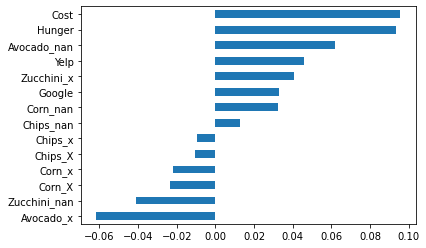

In [167]:
coefs.sort_values().plot.barh();